In [1]:
%load_ext autoreload


In [2]:
import numpy as np
import pandas as pd
from pycaret.time_series import TSForecastingExperiment

In [3]:
%autoreload
import sys
sys.path.append(sys.path[0][0:-4] + 'mikael')
from pipeline import Pipin
pipin = Pipin()

In [4]:
global_fig_settings = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600/13*52,
}

In [5]:
data0 = pipin.get_data("A")

In [6]:
data = data0.copy()
data.drop(columns=[
    "day_of_year",
    "hour",
    "month",
    "year",
    "location:idx"
], inplace=True)

target = "pv_measurement"
categorical_columns = pipin.get_categorical_features(data)
numeric_columns = list(
    set(data.columns) - set(categorical_columns) - {"time"})

data["index"] = pd.to_datetime(data["time"])
data.drop(columns=[ "time"], inplace=True)
data.set_index('index', inplace=True)

In [7]:
def custom_agg_categorical(x):
    if x.empty:
        return np.nan
    else:
        mode_result = x.mode()
        if not mode_result.empty:
            return mode_result.iloc[0]
        else:
            return np.nan
        
numeric_df = data[numeric_columns]
numeric_df.ffill(inplace=True)
numeric_df = numeric_df.resample("H").mean()


categorical_df = data[categorical_columns]
categorical_df = categorical_df.resample("H").apply(custom_agg_categorical)

In [8]:
# groupe by index
# merge the two data sets together
merged_df = pd.merge(categorical_df, numeric_df, left_index=True, right_index=True)

In [9]:
# We want to forecast the next 12 months of data and we will use 3 fold cross-validation to test the models.
fh = 24  # or alternately fh = np.arange(1,13)

eda = TSForecastingExperiment()
ignore_features = pipin.get_irrelevant_features()
eda.setup(
    data=merged_df,
    target=target,
    fh=fh,
    ignore_features=ignore_features,
    numeric_imputation_target="ffill",
    numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings,
    session_id=42,
)

,Description,Value
0,session_id,42
1,Target,pv_measurement
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(34274, 46)"
5,Transformed data shape,"(34274, 46)"
6,Transformed train set shape,"(34250, 46)"
7,Transformed test set shape,"(24, 46)"
8,Rows with missing values,13.5%
9,Fold Generator,ExpandingWindowSplitter


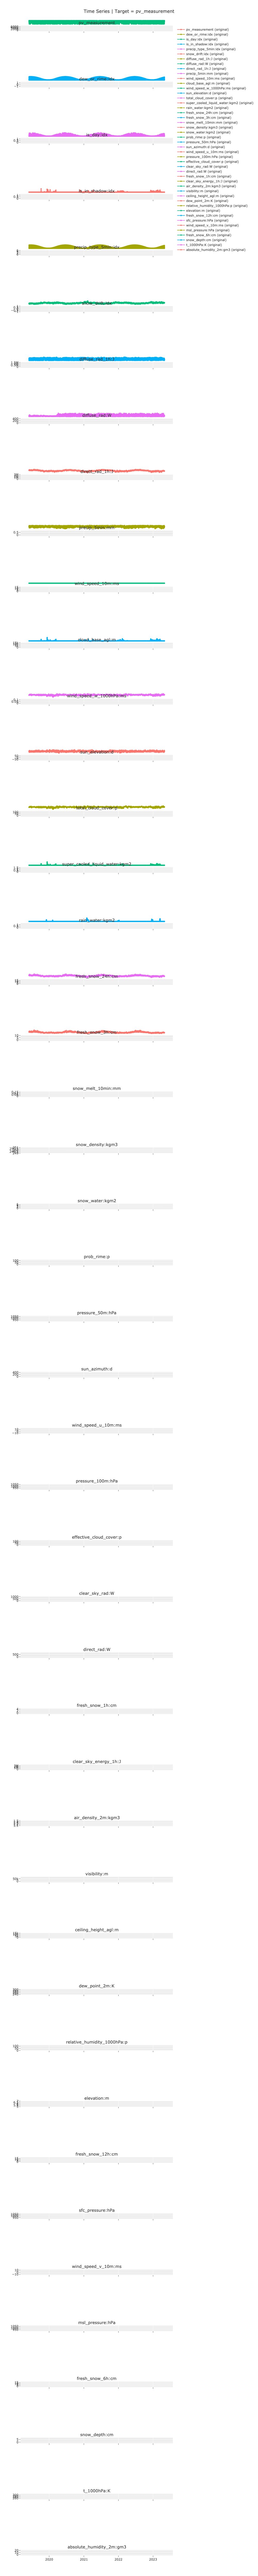

In [19]:
eda.plot_model(fig_kwargs={"renderer": "png", "width": 1000, "height": 10000})


In [20]:
exclude = ["NMHC(GT)"]

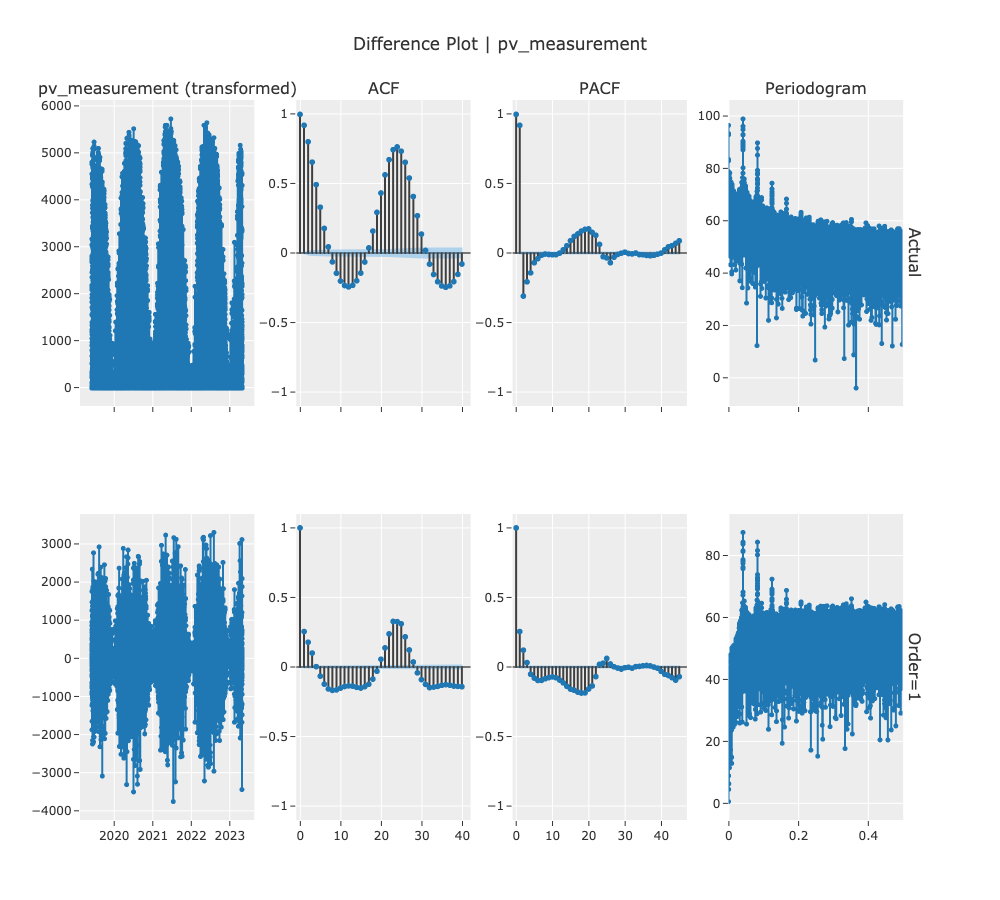

In [11]:
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "height": 900,
        # No need to pass show_dash kwargs when using a plotly-widget
        "resampler_kwargs": {"default_n_shown_samples": 1500 }
    },
    data_kwargs={"acf": True, "pacf": True, "periodogram": True},
    # display_format="plotly-widget",
)

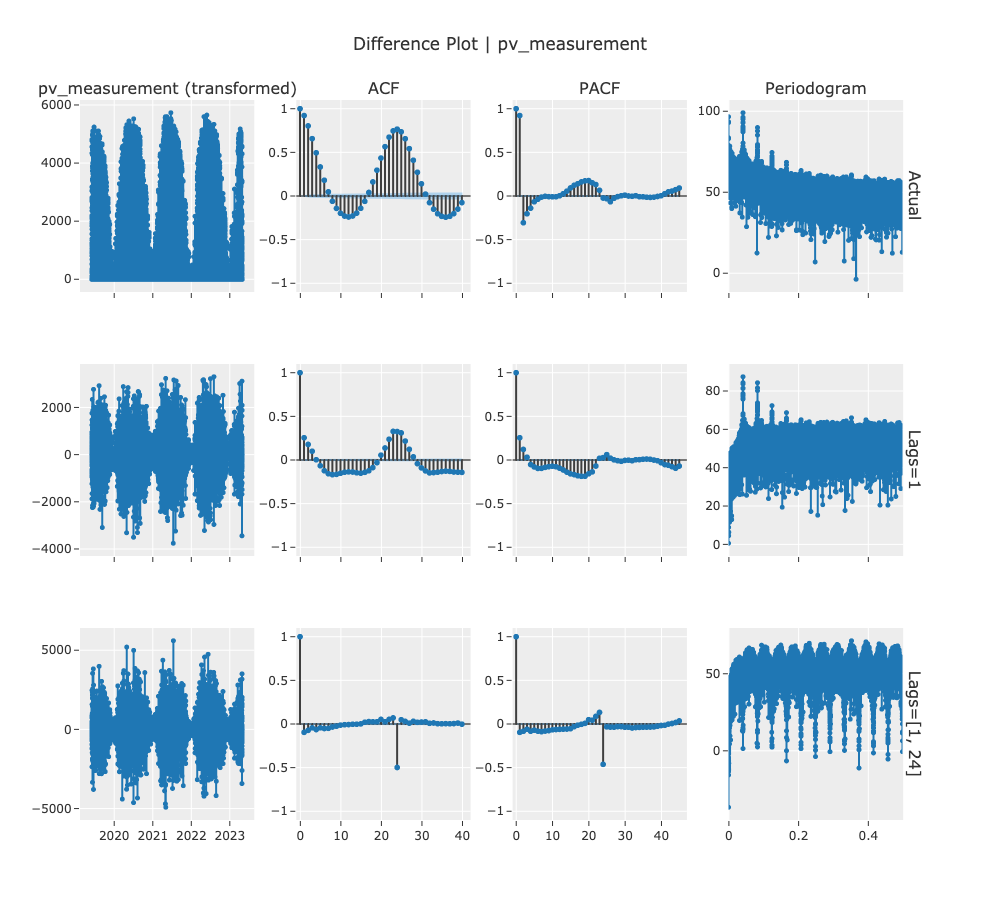

In [12]:
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "height": 900,
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            "show_dash": {"mode": "inline", "port": 8056},
        },
    },
    data_kwargs={
        "lags_list": [1, [1, 24]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    # display_format='plotly-dash',
)


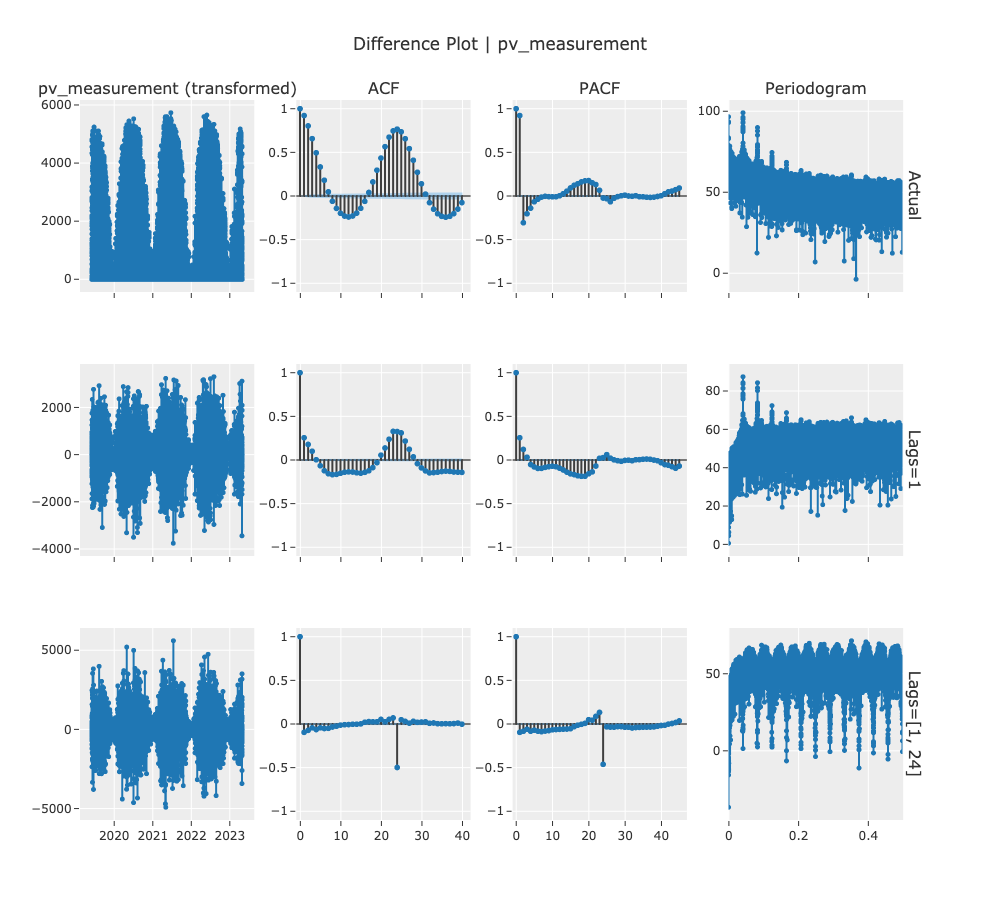

In [13]:
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "height": 900,
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            "show_dash": {"mode": "inline", "port": 8056},
        },
    },
    data_kwargs={
        "lags_list": [1, [1, 24]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    # display_format='plotly-dash',
)


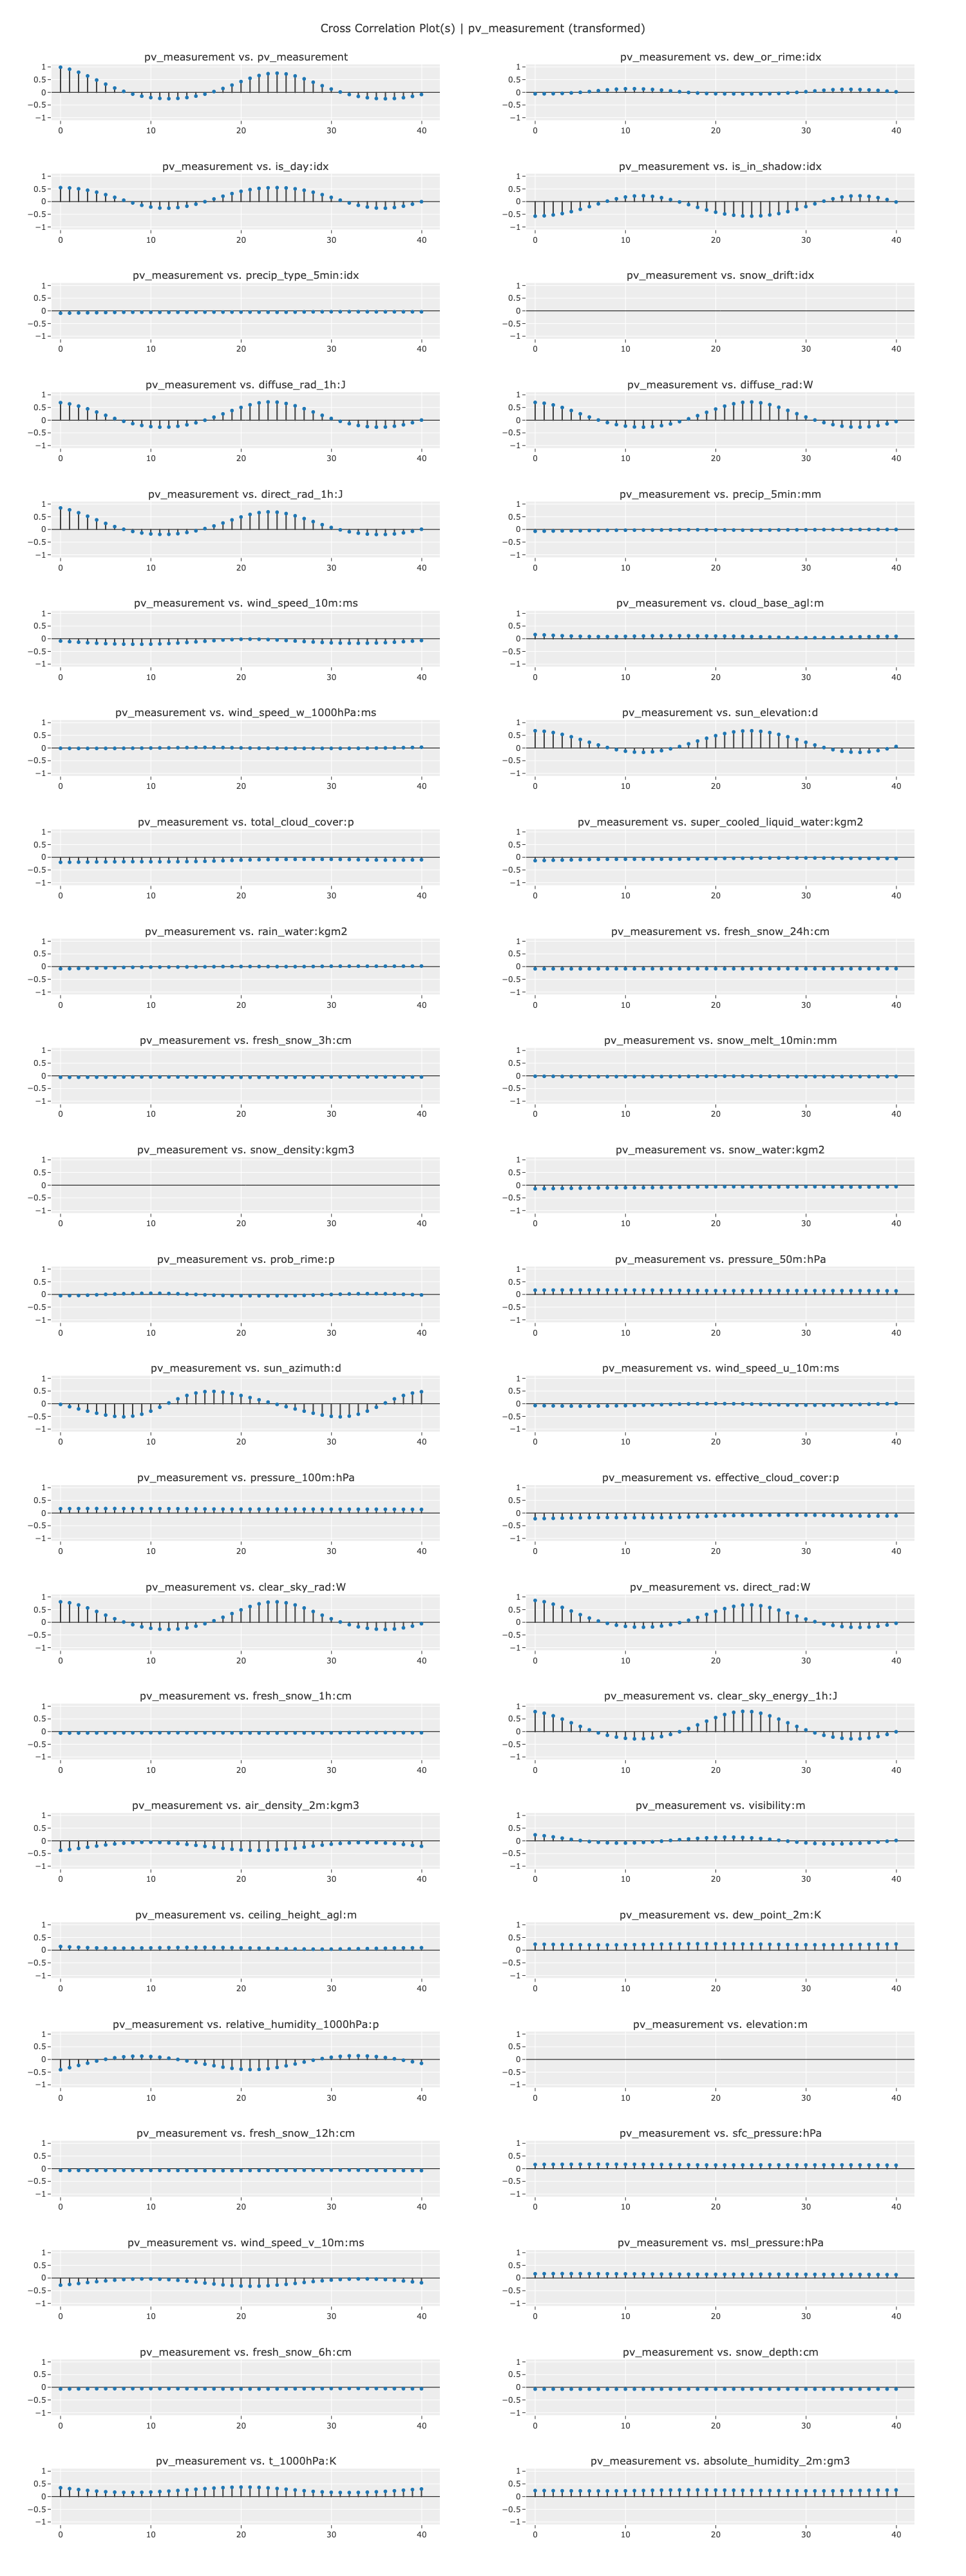

In [14]:
eda.plot_model(plot="ccf", fig_kwargs={"height": 4000, "width": 1500})

In [21]:
exclude.append("AH")

In [ ]:
model = eda.create_model("arima", order=(1,1,0), seasonal_order=(0,1,0,12))